In [1]:
import xarray as xr
import h3
import h3.unstable.vect
import h3.api.numpy_int
import numpy as np

/Users/bbovy/miniconda3/envs/xdggs-dev/lib/python3.12/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [2]:
ds = xr.tutorial.load_dataset('air_temperature').load()
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

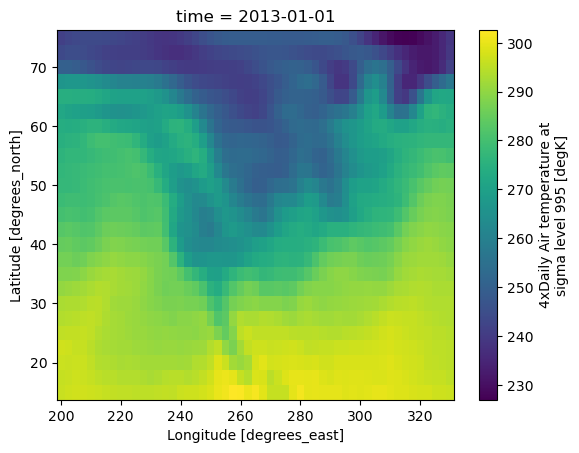

In [3]:
ds.air[0].plot()

In [4]:
resolution = 3

lon, lat = xr.broadcast(ds.lon, ds.lat)
%time index = h3.unstable.vect.geo_to_h3(lat.data.ravel(), lon.data.ravel(), resolution)
index.shape = lon.shape

len(np.unique(index)) / lon.size

CPU times: user 1.73 ms, sys: 1.28 ms, total: 3.01 ms
Wall time: 1.82 ms


0.9690566037735849

In [5]:
index.shape

(53, 25)

In [6]:
ds.lon.shape

(53,)

In [7]:
ds.coords['index'] = ('lat', 'lon'), index.transpose()
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
    index    (lat, lon) uint64 590203960455856127 ... 591508324843782143
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

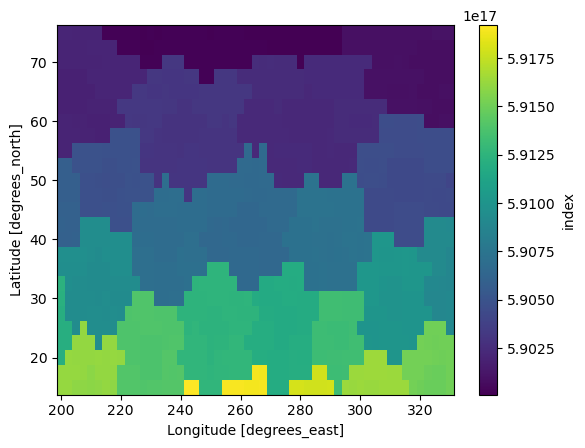

In [8]:
ds.index.plot()

In [9]:
lon_min, lon_max = ds.lon.min().values.item(), ds.lon.max().values.item()
lat_min, lat_max = ds.lat.min().values.item(), ds.lat.max().values.item()

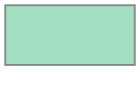

In [10]:
import shapely
bbox_coords = [
    (lon_min - 360, lat_min),
    (lon_min - 360, lat_max),
    (lon_max - 360, lat_max),
    (lon_max - 360, lat_min),
    (lon_min - 360, lat_min)
]
bbox = shapely.Polygon(bbox_coords)
bbox

In [11]:
bbox_coords

[(-160.0, 15.0), (-160.0, 75.0), (-30.0, 75.0), (-30.0, 15.0), (-160.0, 15.0)]

In [12]:
# h3 wants lat first
bbox_coords_lat_first = [(lat, lon) for lon, lat in bbox_coords]
bbox_indexes = np.array(list(h3.api.basic_int.polyfill_polygon(bbox_coords_lat_first, resolution)))
bbox_indexes.shape

(5305,)

In [13]:
ll_points = np.array([h3.api.numpy_int.h3_to_geo(i) for i in bbox_indexes])
ll_points_lon_first = ll_points[:, ::-1]

In [14]:
coords={"cell": bbox_indexes}

# remember to re-add the 360 degree offset
dsi = ds.interp(
    lon=xr.DataArray(ll_points_lon_first[:, 0] + 360, dims="cell", coords=coords),
    lat=xr.DataArray(ll_points_lon_first[:, 1], dims="cell", coords=coords)
)
dsi

<xarray.Dataset>
Dimensions:  (time: 2920, cell: 5305)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
    index    (cell) float64 5.907e+17 5.907e+17 5.907e+17 ... 5.909e+17 5.91e+17
    lon      (cell) float64 299.3 286.2 229.0 237.7 ... 250.0 310.4 314.4 306.4
    lat      (cell) float64 37.81 40.86 33.94 39.28 ... 56.72 52.31 37.79 32.34
  * cell     (cell) int64 590733444024107007 ... 590995677547331583
Data variables:
    air      (time, cell) float64 286.0 275.5 289.4 276.9 ... 266.6 291.5 294.9
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [15]:
dsi2 = dsi.drop_vars(["lon", "lat", "index"])
dsi2.cell.attrs = {"grid_name": "h3", "resolution": resolution}
dsi2.to_netcdf("data/h3_example.nc")
dsi2

<xarray.Dataset>
Dimensions:  (time: 2920, cell: 5305)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * cell     (cell) int64 590733444024107007 ... 590995677547331583
Data variables:
    air      (time, cell) float64 286.0 275.5 289.4 276.9 ... 266.6 291.5 294.9
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...